In [3]:
import numpy as np
import pandas as pd

%matplotlib inline
import pylab
import seaborn as sns
sns.set_style("whitegrid")

# Load Data

In [135]:
train = pd.read_csv("train.csv")
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


# Clean Data

On the outset it seems that there are some issues with the number of observations for the columns (e.g., Age, Cabin, Embarked).

    * Gender is non numeric
    * Embarked is also a string
    * Age -- Missing and incorrect data


In [136]:
# Cleanup Gender and Embarked
train['Sex'] = np.where(train['Sex'] == 'male', 0, 1)
train['Embarked'] = train['Embarked'].fillna('Z').map(dict(C=0, S=1, Q=2, Z=3))

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,hasage
Survived,,,,,,,,,
0,447.016393,2.531876,0.147541,30.626179,0.553734,0.329690,22.117887,0.948998,0.227687
1,444.368421,1.950292,0.681287,28.343690,0.473684,0.464912,48.395408,0.827485,0.152047


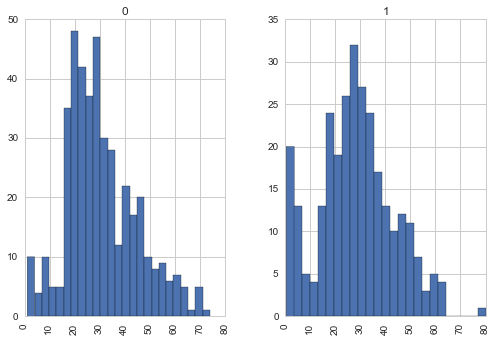

In [137]:
# AGE -- quickly look at data
train['hasage'] = np.isnan(train['Age'])
train.hist('Age', by='Survived', bins=25)
train.groupby('Survived').mean()

There is a clear difference in the distributions in ages between thoes who survived and not.  Also from the table you can see the differences in the mean values of the passenger class (pclass), ages, and Fares.  Note it is also more likely to have a missing age if you did not survive.  Rather than attempting to model the missing ages, I include -1 age class

In [138]:
# Age is missing values
train['Age'] = np.where(np.isfinite(train['Age']), train['Age'], -1)

# Feature Creation

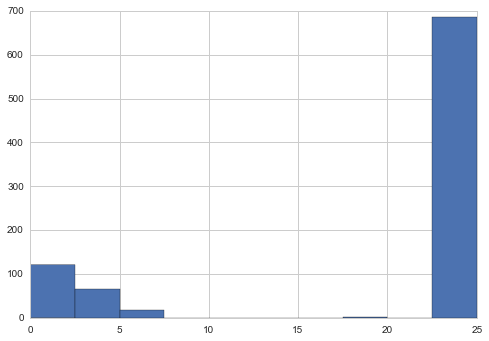

In [139]:
# Remap cabin to a numeric value depending on the letter
m = {chr(i+97).upper():i for i in range(26)}
shortenmap = lambda x: m[x[0]]
train['cleancabin'] = train['Cabin'].fillna('Z').apply(shortenmap)
train['cleancabin'].hist()

In [182]:
# Get person title / family name
# These might be overfitting the data since the title is correlated with gender
# and family name and siblings, however they seems to add more information.
train['family'] = train['Name'].apply(lambda x: x.split(',')[0])
train['title'] = train['Name'].apply(lambda x: x.split(',')[1].split()[0])

nfamily = dict(train['family'].value_counts())
train['nfamily'] = train['family'].map(nfamily)

ntitle = {title:i for i,title in enumerate(np.unique(train['title']))}
train['ntitle'] = train['title'].map(ntitle)

In [183]:
train.groupby('Survived').mean()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,hasage,cleancabin,nfamily,ntitle
Survived,,,,,,,,,,,,
0,447.016393,2.531876,0.147541,23.425319,0.553734,0.329690,22.117887,0.948998,0.227687,22.216758,1.939891,10.520947
1,444.368421,1.950292,0.681287,23.882076,0.473684,0.464912,48.395408,0.827485,0.152047,16.017544,1.789474,9.792398


# Classify!

First test different techniques to see how well they predict the training set.

In [218]:
predictors = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked", 'cleancabin', 'nfamily', 'ntitle']

In [219]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostRegressor
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn import cross_validation

### Logistic Regression

In [220]:
scores = cross_validation.cross_val_score(
    LogisticRegression(random_state=0),
    train[predictors],
    train["Survived"],
    cv=3
)

print('{:0.1f}'.format(100*scores.mean()))

78.0


### Random Forest

In [199]:
scores = cross_validation.cross_val_score(
    RandomForestClassifier(
        random_state=0,
        n_estimators=150,
        min_samples_split=4,
        min_samples_leaf=2
    ),
    train[predictors],
    train["Survived"],
    cv=3
)

print('{:0.1f}'.format(100*scores.mean()))

82.0


### Gradient Boost

In [204]:
scores = cross_validation.cross_val_score(
    GradientBoostingClassifier(n_estimators=100, 
                               learning_rate=1.0, 
                               max_depth=1, 
                               random_state=0),
    train[predictors],
    train["Survived"],
    cv=3
)
print('{:0.1f}'.format(100*scores.mean()))

81.5


### Support Vector Machine Classifier


In [ ]:
scores = cross_validation.cross_val_score(
    SVC(random_state=0),
    train[predictors],
    train["Survived"],
    cv=3
)
print('{:0.1f}'.format(100*scores.mean()))

### Support Vector Machine Classifier with AdaBoost?!

Broken!

In [ ]:
scores = cross_validation.cross_val_score(
    AdaBoostRegressor(SVC(kernel='poly', random_state=0), random_state=0, n_estimators=500, learning_rate=0.5),
    train[predictors],
    train["Survived"],
    cv=3
)
print('{:0.1f}'.format(100*scores.mean()))

### AdaBoost

In [223]:
scores = cross_validation.cross_val_score(
    AdaBoostClassifier(random_state=0, n_estimators=100),
    train[predictors],
    train["Survived"],
    cv=3
)
print('{:0.1f}'.format(100*scores.mean()))

80.9


### K Nearest Neighbors + Bagging

In [224]:
bagging = BaggingClassifier(KNeighborsClassifier(), max_samples=0.5, max_features=0.5, random_state=0)
scores = cross_validation.cross_val_score(
    bagging,
    train[predictors],
    train["Survived"],
    cv=3
)
print('{:0.1f}'.format(100*scores.mean()))

78.6


### Voting Classifier with multiple classifiers

In [226]:
est = [('GNB', GaussianNB()), 
       ('LR', LogisticRegression(random_state=1)), 
       ('RFC',RandomForestClassifier(random_state=1))]
alg = BaggingClassifier(VotingClassifier(est, voting='soft'), max_samples=0.5, max_features=0.5)


scores = cross_validation.cross_val_score(
    alg,
    train[predictors],
    train["Survived"],
    cv=3
)
print('{:0.1f}'.format(100*scores.mean()))

79.6


# Measure feature Strength

1 Sex 0.251438353311
5 Fare 0.18581239403
2 Age 0.162418133842
0 Pclass 0.0810518030017
9 ntitle 0.0723688407168
7 cleancabin 0.0694829822141
8 nfamily 0.0585723690865
3 SibSp 0.0407668082802
6 Embarked 0.0333326445217
4 Parch 0.0328343514417
10 hasage 0.011921319555


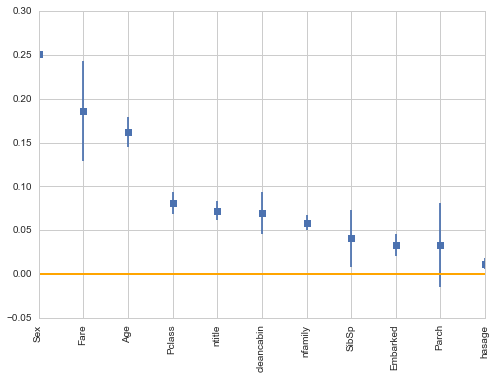

In [240]:
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)
forest.fit(train[predictors], train['Survived'])
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

ind = np.arange(len(indices))

pylab.errorbar(ind, importances[indices], yerr=std, fmt='s')
pylab.xticks(ind, [predictors[i] for i in indices], rotation='vertical')
pylab.axhline(0.0, color='orange', lw=2)
for index in indices:
    print index, predictors[index], importances[index]